<a href="https://colab.research.google.com/github/nudro/widscharlottesville/blob/master/WiDS_Local_Py35_005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  A "Tour de Package" - Supervised Machine Learning Packages in Python
<b>Introduction</b><br>


<b>Version</b>: Local, Macbook Pro, <u>Processor</u>: 2.8 GHz Intel Core i7; <u>Memory</u>: 16 GB 2133 MHz LPDDR3
<b>Python</b> 3.5

**MAKE SURE PACKAGES ARE INSTALLED**:


*   h2o
*   keras
* wordcloud
* the stopwords corpus from nltk.download()




In [0]:
#this is how you would install a package in this Jupyter Notebook
import sys
!{sys.executable} -m pip install h2o
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install stopwords

    100% |████████████████████████████████| 130.6MB 151kB/s 
    100% |████████████████████████████████| 51kB 15.6MB/s 
  Running setup.py bdist_wheel for h2o ... - \ | / - \ | / done
  Stored in directory: /content/.cache/pip/wheels/79/62/a8/87e5ae300b48b21551cf191ff38ddec6acceb0c6b6b5d8c7fe
  Running setup.py bdist_wheel for tabulate ... - done
  Stored in directory: /content/.cache/pip/wheels/2a/85/33/2f6da85d5f10614cbe5a625eab3b3aebfdf43e7b857f25f829
Successfully built h2o tabulate
    100% |████████████████████████████████| 51kB 906kB/s 
  Running setup.py bdist_wheel for stopwords ... - \ done
  Stored in directory: /content/.cache/pip/wheels/39/fa/c7/c4c5111e658f5c58465d948165dc3395a3c10ff57f4cd20356
Successfully built stopwords


In [0]:
#then to make sure stopwords is installed
import nltk
nltk.download()
#select 'd' and enter 'stopwords'

In [0]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
%%time

# Open our new sheet and read some data.
worksheet = gc.open('Reviews.csv')

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
print(rows)

data = pd.DataFrame.from_records(rows)

NameError: ignored

In [0]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
#let's look at the first review
data.iloc[0, 9]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [0]:
#let's look at the last review
data.iloc[568453, 9]

'I am very satisfied ,product is as advertised, I use it on cereal, with raw vinegar, and as a general sweetner.'

<b>Let's cut the dataset down just for this tutorial.</b> So that people with less powerful CPUs can run the tutorial.

In [0]:
#For the purposes of the tutorial so that others can run this on their CPU, I'm going to cut this dataset in QUARTER

from __future__ import division
tenth = np.int(len(data)/10)

In [0]:
#confirm 'half' is an integer which is required in order to slice the dataframe - float won't work
tenth

56845

In [0]:
data_tu = data[:tenth]
print(data_tu.shape)


(56845, 10)


In [0]:
data_tu.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [0]:
#export in case I need to reload again
#data_tu.to_csv("/Users/catherineordun/Documents/Data/data_quartered_wids.csv")

# Preprocessing
We will preprocess this data in three ways: 
- Normalize the datetime 
- As a part of each package to handle text, we will: 

- - Use TFIDF Vectorizer in Scikit-learn
- - Tokenize and apply Word2Vec in H2O
- - Use TensorFlow to preprocess in Keras

In [0]:
#if I need to reload this file
#data_tu = pd.read_csv("/Users/catherineordun/Documents/Data/data_quartered_wids.csv", index_col = 0)

In [0]:
data_tu.shape

(56845, 10)

In [0]:
data_tu.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

<b>Examine a few random comments</b>

In [0]:
#the 10th comment
list(data_tu.iloc[9][['Text', 'Summary']])

['This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.',
 'Healthy Dog Food']

In [0]:
#the last comment
list(data_tu.iloc[56844][['Text', 'Summary']])

["Love this chocolate! If you've ever tried to temper with the crappy chocolate you find at the grocery store, you will instantly be grateful for this stuff. It tempered on my first try and tasted wonderful! Definitely worth the money.",
 'Love love love this chocolate']

<b>Normalize the Datetime</b>

In [0]:
#First let's look at the current dtype for the date
data_tu.dtypes
#We can see that 'Time' is currently an int64. We need to change this to datetime.

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [0]:
import datetime as datetime

#string format time to YY
data_tu['datetime'] = data_tu['Time'].map(lambda x: (datetime.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d')))


/home/cordun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [0]:
#pandas conversion to datetime variable 
data_tu['datetime'] = pd.to_datetime(data_tu['datetime'])
print(data_tu.dtypes)

Id                                 int64
ProductId                         object
UserId                            object
ProfileName                       object
HelpfulnessNumerator               int64
HelpfulnessDenominator             int64
Score                              int64
Time                               int64
Summary                           object
Text                              object
datetime                  datetime64[ns]
dtype: object


/home/cordun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
data_tu.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,datetime
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-26
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-06
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-17


# Basic EDA

In [0]:
import seaborn as sns

<b>Average Number of Reviews by Year</b>
- Average Number of Reviews by Year
- Average Score per Year
- Average Annual Number of Reviews and Amazon Score
- Exploration of Low-Score Comments for a Product = Greenies

The majority of the reviews are in the year 2011 and 2012. 

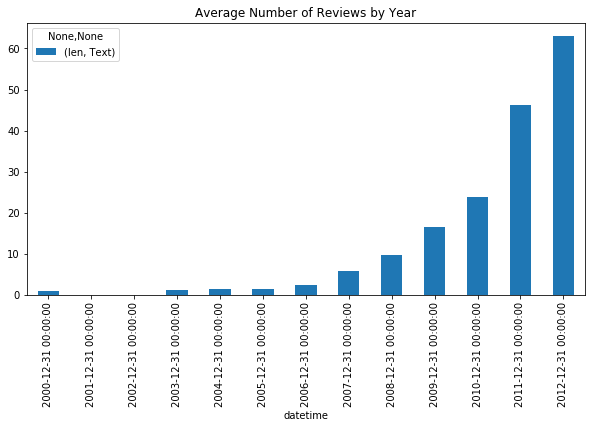

In [0]:
reviews = (pd.pivot_table(data_tu,index=["datetime"],values=["Text"],aggfunc=[len])).resample('A').mean()
reviews.fillna(value=0, inplace=True)
reviews.plot(kind='bar', figsize=(10,5))
plt.title('Average Number of Reviews by Year')
plt.show()

<b>Average Review Score per Year</b>

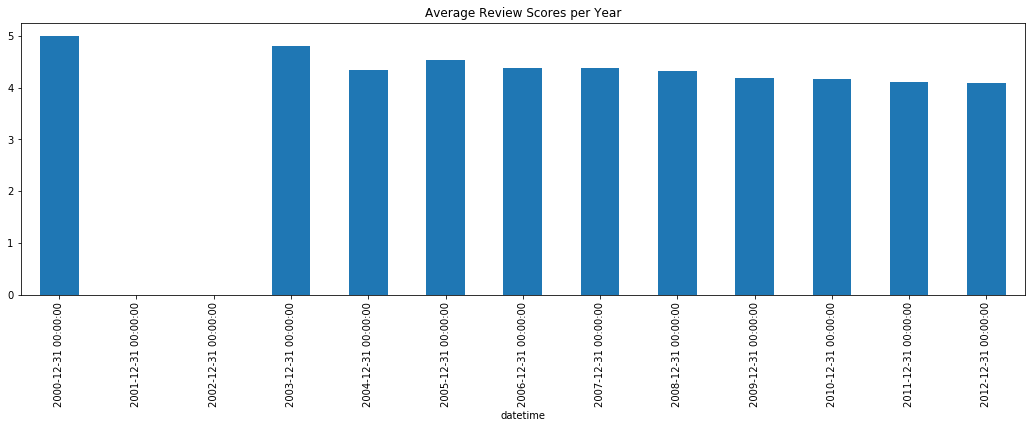

In [0]:
#Amazon Score for all time 
((data_tu.set_index('datetime')).resample('A').mean())['Score'].plot(kind='bar', figsize=(18,5)) 
plt.title('Average Review Scores per Year')
plt.show()

<b>Average Annual Number of Reviews and Amazon Score</b>

In [0]:
reviews_and_scores = (pd.pivot_table(data_tu,index=["datetime"],
                       values=["Text", "Score"],
                       aggfunc={"Text": lambda x: len(x),
                               "Score": lambda x: x.mean()})).resample('A').mean()

The average Amazon Rating is still pretty positive (greater than 4) per year. But as the number of reviews have increased, the rating for products have declined. 

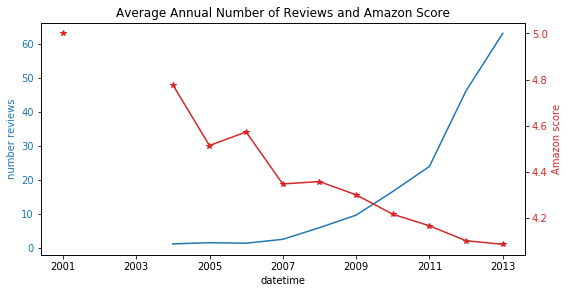

In [0]:
t = (reviews_and_scores.reset_index())['datetime']
data1 = (reviews_and_scores.reset_index())['Text']
data2 = (reviews_and_scores.reset_index())['Score']

fig, ax1 = plt.subplots(figsize=(8,4))

color = 'tab:blue'
ax1.set_xlabel('datetime')
ax1.set_ylabel('number reviews', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Amazon score', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color, marker='*')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Average Annual Number of Reviews and Amazon Score')
plt.show()

<b>Product IDs and their Average Review Scores</b>
In this subsampled dataset, there are 36781 unique Product IDs. An histogram shows the distribution of the average scores for each Product ID, with almost half with greater than 4.5-star review. This trend is consistent when looking at the distribution of the scores for all comments. 

In [0]:
print("In this dataset, there is", data_tu['ProductId'].nunique(), "unique products.")

In this dataset, there is 7228 unique products.


In [0]:
#Distribution of the Average Review Scores by ProductID
products = pd.pivot_table(data_tu,index=["ProductId"], values=["Score"], 
                      aggfunc={"Score": lambda x: x.mean()})


In [0]:
products.head()

,Score
ProductId,
2734888454,3.5
B00002NCJC,4.5
B00002Z754,5.0
B00005V3DC,5.0
B00006IDJO,1.0


Products have a different number of reviews - not all are equal.

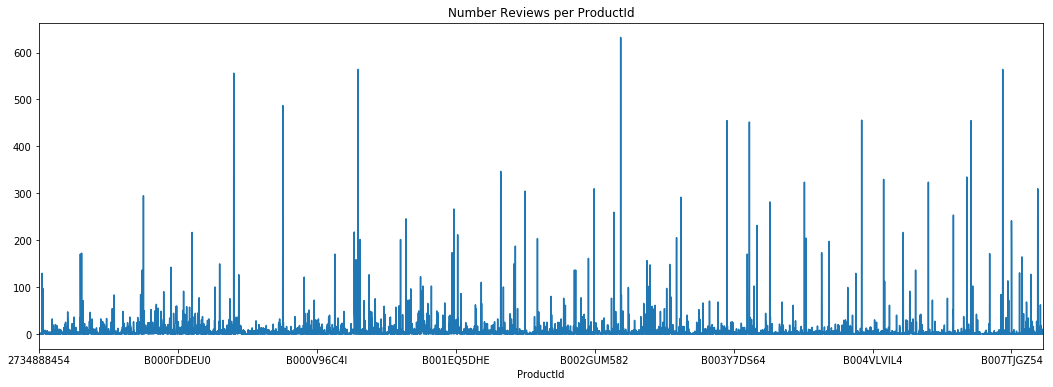

In [0]:
#pivot table
products_list = pd.pivot_table(data_tu,index=["ProductId"],values=["Score"],aggfunc=[np.mean,len])

#multindex and plot
(products_list['len']['Score']).plot(figsize=(18, 6))
plt.title('Number Reviews per ProductId')
plt.show()

Give me the Top 10 ProductId's with the most comments.

In [0]:
(products_list.sort_values([('len', 'Score')], ascending=False)).head(10)

,mean,len
,Score,Score
ProductId,,
B002QWP89S,4.588608,632
B0013NUGDE,4.310284,564
B007M83302,4.310284,564
B000KV61FC,3.411871,556
B000PDY3P0,4.355236,487
B004SRH2B6,3.671053,456
B006N3IG4K,3.934066,455
B003VXFK44,3.934066,455


<h3>Let's look at all the comments for a specific Product Id with low scores of 1 or 2.</h3>
- If using the 5th set: We'll use from the products_list, this product: B0026RQTGE
- If using the 10th set: B002QWP89S
- <b>Note:</b> This part of the EDA dealing with NLP is outside the scope of this tutorial, so I'll run through this part at a high level. But happy to share this code with you. The goal here is to get a general sense of what people are complaining about that made them rate this product low.

In [0]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

<img src = "https://img.chewy.com/is/image/catalog/50345_MAIN._AC_SL1500_V1487798795_.jpg" width=300 height=300>

In [0]:
selected_product = data_tu.loc[(data_tu['ProductId'] == 'B002QWP89S')]

print((selected_product.reset_index()).Text.sum())

my 12 year old sheltie has chronic brochotitis, been on meds for three years, these help with the coughing fits at night. so I like them!!!<br /> one bite and both my dogs are addicted!!! be warned!!! 7 pm both shelties are on my lap howling for the drug fix! I am a dog trainer and have never seen  anything like it....<br /><br />three weeks later,, the beloved sheltie got a bowel blockage from these, use with caution.<br />if the cat gets too many she has the runs....<br />sheltie did better when i upped her thryoid meds, and gave her doggie asthma meds.<br />so it worked better for the 18 year old cat, who also has asthma.These are genuine Greenies product, not a knockoff.  My dogs love them!  It is their favorite treat.  I have 2 small dogs, both under 10 lbs. and the Teenie size is perfect for them.  I paid $22.37 for this 96-pack and it is by far the best price I have found anywhere.  I wish these were part of the Subscribe & Save program.Our dogs love Greenies, but of course, whi

In [0]:
low_rv_score_prod_comments = data_tu.loc[(data_tu['ProductId']=='B002QWP89S') & (data_tu['Score'] <= 2)]
print(len(low_rv_score_prod_comments))


39


In [0]:
low_rv_score_prod_comments[['Summary', 'Text', 'Score']][:5]

,Summary,Text,Score
21014,Check Contents First,"Half way through the supply, I noticed that th...",1
21019,very dangerous product for dogs,i bought this for my dog - he loved it. howev...,1
21124,Dog got sick,Been buying greenies for years. Decide to try...,2
21282,Dog goes crazy for these,EDIT: I had been giving my dog a half of one o...,2
21306,Greenies Lite - Not for dogs who had the taste...,My little dog who's rather picky about his tre...,1


<b>TF-IDF:</b> In dealing with text, no tutorial is complete with introducing TF-IDF which is the term-frequency inverse-document-frequency.  This is essentially a weighting formula that upweights words that occur frequently within a sentence review but not all across all reviews, like common words such as 'these', 'those'. 


<img src="https://deeplearning4j.org/img/tfidf.png">

In [0]:
#going to vectorize one term and then phrases of two terms 
vectorizer = TfidfVectorizer(ngram_range=(1,2))

#make a corpus that the vectorizer can read as a list
corpus = low_rv_score_prod_comments['Text'].tolist()
matrix = vectorizer.fit_transform(corpus)

In [0]:
matrix

<39x4308 sparse matrix of type '<class 'numpy.float64'>'
	with 6578 stored elements in Compressed Sparse Row format>

In [0]:
"""

Note: Since version 0.15, the tf-idf score of each feature can be retrieved via 
the attribute idf_ of the TfidfVectorizer object:

"""
idf = vectorizer.idf_

In [0]:
idf.shape

(4308,)

In [0]:
terms = dict(zip(vectorizer.get_feature_names(), idf))

In [0]:
terms

{'00': 3.9957322735539909,
 '00 for': 3.9957322735539909,
 '00 later': 3.9957322735539909,
 '000': 3.9957322735539909,
 '000 on': 3.9957322735539909,
 '100': 3.9957322735539909,
 '100 digestible': 3.9957322735539909,
 '12hrs': 3.9957322735539909,
 '12hrs later': 3.9957322735539909,
 '13': 3.5902671654458267,
 '13 dogs': 3.9957322735539909,
 '13 of': 3.9957322735539909,
 '13 pet': 3.9957322735539909,
 '15': 3.9957322735539909,
 '15 lb': 3.9957322735539909,
 '17': 3.9957322735539909,
 '17 greenies': 3.9957322735539909,
 '18': 3.9957322735539909,
 '18 years': 3.9957322735539909,
 '2003': 3.9957322735539909,
 '2003 where': 3.9957322735539909,
 '2011': 3.9957322735539909,
 '2011 and': 3.9957322735539909,
 '2013': 3.9957322735539909,
 '2013 so': 3.9957322735539909,
 '25': 3.5902671654458267,
 '25 00': 3.9957322735539909,
 '25 50': 3.9957322735539909,
 '27': 3.3025850929940459,
 '27 count': 3.9957322735539909,
 '27 greenies': 3.9957322735539909,
 '27 ounce': 3.9957322735539909,
 '27 treats': 

In [0]:
from wordcloud import WordCloud

In [0]:
# Initialize the word cloud

wc = WordCloud(
    background_color="white",
    max_words=2000,
    width = 1024,
    height = 720,
    stopwords=stopwords.words("english")
)

# Generate the cloud

wc.generate_from_frequencies(terms)
wc.to_file("word_cloud.png")

![word_cloud.png](attachment:word_cloud.png)

# SciKit-Learn
Scikit-Learn is probably the most popular Python machine learning package out there. It was the first package I worked in and has a vibrant and well documented community.  You can use sklearn for unsupervised and supervised machine learning. Today we will build a supervised multi-class classification model for text classification. You've already seen how we used sklearn for TF-IDF processing of the product comments. 

We'll try out two algorithms: 
- Multinomial Naive Bayes 
- Logistic Regression
- Support Vector Machine

![scikit-learn-logo-notext.png](attachment:scikit-learn-logo-notext.png)

In [0]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold

/home/cordun/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<h3>Part 1 - Data for the Model</h3><br>
For all our models moving forward in the three packages, we'll keep it simple and use as our input features simply the Amazon Reviews `Text` and for our output targets the Amazon Review Score `Score`. 

In [0]:
data_for_model = data_tu[['Score', 'Text']].copy()

In [0]:
data_for_model.head(3)

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...


In [0]:
#make 'Score' categorical 
data_for_model['Score'] = data_for_model['Score'].astype('category')

print(data_for_model.dtypes)

Score    category
Text       object
dtype: object


<b>Partition the dataset:</b>
- Training Set to fit the model and run cross-validation on 
- Validation Set as a "preemptive" test or hold-out set like a first-gate quality check
- Test Set to predict 

In [0]:
#First partition a training and test set
#converts to arrays
X = data_for_model['Text']
y = data_for_model['Score']


Vectorize all the Text just like we did with the Greenies Dog Treats. These will be our `features` and `labels` that we'll split on. 

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1')

features = tfidf.fit_transform(X).toarray()

labels = y

features.shape

(56845, 14152)

In [0]:
#features is a sparse array for of 14152 features (terms) (in this vectorization I only included unigrams)
features

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [0]:
#split the dataset by 70% and 30%
X_train, X_test, y_train, y_test= train_test_split(features, labels, test_size=0.30, random_state=0)

<b><font color=#ff0000>TIP:</b></font> I usually always print out the shapes of my partitioned sets.

In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(39791, 14152)
(17054, 14152)
(39791,)
(17054,)


<h3>Part 2 - Prepare and Fit a Multinomial Bayes Model</h3><br>

A basic and effective technique for document classification using the Bayes Probability Theorem.<br>

<img src="http://www.saedsayad.com/images/Bayes_rule.png">

<u>Calculate the Priors:</u><br>
- Probability(1-Star Review) = P(1)
- Probability(2-Star Review) = P(2)
- and so on...

<u>Calculate the Likelihood (aka Conditional Probabilities):</u><p>
P('treats'|5) = [(count('treats', 5) + 1] <b>divided by</b> [(count(5-star reviews) + |V|]; where V is the set(words), or number of all unique words<p>

<u>Calculate Probability for a Document (or an Amazon Review, in our case)</u><p>
P(5|this_review) = P(5) * P('word1'|5) * P('word2'|5) * P('word3'|5) ... * P('word_k'|5)<br>
P(5|this_review) = 0.4 * 0.05256 * 0.00345 * 0.012 * 0.004 = 0.0000000348<p>
Repeat for P(4|this review)... to P(1|this_review)<p>
The probability with the greatest value is the catgory (the star-rating) of the Amazon Review.


<b>2 - Fit the MultinomialNB() Model</b>

In [0]:
mn_clf = MultinomialNB().fit(X_train, y_train)

<b>3- Cross Validate on the Training Set</b>

<b>What is cross validation?</b>

Cross validation is a strategy to prevent overfitting.

<img src= "http://blog-test.goldenhelix.com/wp-content/uploads/2015/04/B-fig-1.jpg">

In [0]:
from sklearn.cross_validation import cross_val_score
from scipy.stats import sem


cv = cross_val_score(mn_clf, X_train, y=y_train, scoring='accuracy', cv=5)
print(cv)
print("Mean score:{0:.3f}(+/-{1:.3f})".format(np.mean(cv),sem(cv)))

[ 0.63245823  0.6307325   0.63470721  0.63277617  0.63084465]
Mean score:0.632(+/-0.001)


<b>4 - Evaluation Metrics</b>
- Classification Report
- Confusion Matrix
- Learning Curve

In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

<b>Predict</b> On the X_test set, that if you remember, we vectorized early on.

In [0]:
y_pred = mn_clf.predict(X_test)

We can see here that we want all the numbers to line up totally on the diagonal. For example, the model predicted that 186 of the 1671 1-Star rating reviews were 1-star (prediction).  This is right! But unfortunately, it predicted that 11 of them were a 4-star, and that's wrong. Worse, it predicted that a huge number, 1473 of the reviews that are actually 1-star are a 5-star. 

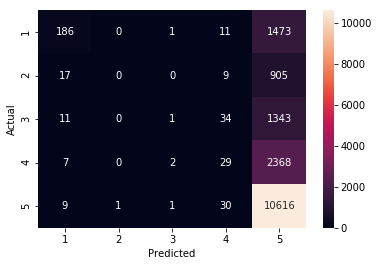

In [0]:
conf_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=['1', '2', '3', '4', '5'], yticklabels=['1', '2', '3', '4', '5'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

It confuses many of the reviews as being a 5-star, which shows in our f1-score below. You can see our f1-scores for 2-star, 3-star, and 4-star are especially bad.

<img src="https://chrisalbon.com/images/machine_learning_flashcards/F1_Score_print.png" width="400" height="400">

In [0]:
print(sklearn.metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.81      0.11      0.20      1671
          2       0.00      0.00      0.00       931
          3       0.20      0.00      0.00      1389
          4       0.26      0.01      0.02      2406
          5       0.64      1.00      0.78     10657

avg / total       0.53      0.64      0.51     17054



<img src = "https://i.stack.imgur.com/z5WJHm.jpg">

In [0]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.63515890700129007

<h3>Part 3 - Automate with a Pipeline</h3>

<b>Let's fit a few models using a pipeline.</b>
- In the pipeline, we'll ask the it to first vectorize the review comments.
- Then the pipeline will instantiate a classifier.<br>
![WiDS%20Tutorial.png](attachment:WiDS%20Tutorial.png)

We will use our original non-vectorized dataset X and y to run through the pipeline for three different classifiers.

In [0]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.30, random_state=0)

<b>Something you might want to try yourself - Challenge Question:</b> How does the cross validation scores change if we add a new parameter of `ngram_range=(1, 2)`?

In [0]:

clf_1 = Pipeline([
    ('vect', TfidfVectorizer(decode_error='ignore', strip_accents='unicode', stop_words='english')),
    ('clf', MultinomialNB()),
])


clf_2 = Pipeline([
    ('vect', TfidfVectorizer(decode_error='ignore', strip_accents='unicode', stop_words='english')),
    ('clf', LogisticRegression()),
])


clf_3 = Pipeline([
    ('vect', TfidfVectorizer(decode_error='ignore', strip_accents='unicode', stop_words='english')),
    ('clf', LinearSVC()),
])

In [0]:
#Function to perform and evaluate a cross validation on the training set
from sklearn.model_selection import cross_validate

def evaluate_cross_validation(clf, X, y, K):
    cv = KFold(len(y), n_folds = K, shuffle=True)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    print(clf.named_steps['clf'], scores)
    print("Mean score:{0:.3f}(+/-{1:.3f})".format(np.mean(scores),sem(scores)))


In [0]:
%%time

"""
On a CPU, this takes approximately 9min 45s on a MacBook Pro:

Processor: 2.8 GHz Intel Core i7
Memory: 16 GB 2133 MHz LPDDR3

"""

#Evaluate each model using the K-fold cross-validation with 5 folds
clfs = [clf_1, clf_2, clf_3]

for clf in clfs:
    evaluate_cross_validation(clf, X_train, y_train, 5)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) [ 0.63022993  0.62025635  0.63118874  0.62930385  0.61887409]
Mean score:0.626(+/-0.003)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) [ 0.69217238  0.69791405  0.69879367  0.69163106  0.6999246 ]
Mean score:0.696(+/-0.002)
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) [ 0.69883151  0.7005529   0.7036944   0.70771551  0.71098266]
Mean score:0.704(+/-0.002)
CPU times: user 4min 1s, sys: 11.8 s, total: 4min 12s
Wall time: 1min 1s


<b>Model Selection</b>

We can see that our last classifier, clf_3, the LinearSVC model performs the best with an average cross-validation accuracy of 0.704. Based on that, let's predict for X_test using the clf_3 and print out a classification report and confusion matrix.

In [0]:
#original 

def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    
    clf.fit(X_train, y_train)
    
    print("Accuracy on training set:")
    print(clf.score(X_train, y_train))
    print("Accuracy on testing set:")
    print(clf.score(X_test, y_test))
    
    y_pred = clf.predict(X_test)
    
    print("Classification Report:")
    print(sklearn.metrics.classification_report(y_test, y_pred, target_names = ['1', '2', '3', '4', '5']))
    print("Confusion Matrix:")
    print(sklearn.metrics.confusion_matrix(y_test, y_pred))

We'll see that using a SVM increased our F1-Score a bit more, enabling the model to better predict the correct classes. A good tutorial that discusses the linearSVC model, which is a linear kernel function of the Support Vector Machine is by Alice Zhou, here's her video: https://www.youtube.com/watch?v=N1vOgolbjSc. As well as one by Brandon Ruhrer: https://www.youtube.com/watch?v=-Z4aojJ-pdg

One of the key elements of understanding SVM's is what's called the "kernel trick". This is essentially a way to best slice your data using a "hyperplane". There are different types of kernels, this one is a linear kernel.  There are radial basis functions (rbf), polynomial, and sigmoid kernels. 

<img src="http://cagriemreakin.com/wp-content/uploads/2017/10/kernel.png">

The trick of bending this piece of paper in the right way to get that hyperplane that separates let's say, per Brandon, good to eat plums from bad to eat plums, is calculated through a formula called the 'kernel'. One drawback is the calculation time for large datasets to compute the kernel.

<img src="https://i.ytimg.com/vi/-Z4aojJ-pdg/hqdefault.jpg">

<b>Something you might want to try yourself - Challenge Question:</b> How would the `clf_3` change if we changed its penalty parameter of 'C' to a lower value? My guess is that when C decreases, it makes a "soft margin" separating our 5 different classes. This may mean a less accurate score. You try!

In [0]:
%%time

#I chose to use model clf_3

train_and_evaluate(clf_3, X_train, X_test, y_train, y_test)


Accuracy on training set:
0.88763790807
Accuracy on testing set:
0.704057699074
Classification Report:
             precision    recall  f1-score   support

          1       0.63      0.60      0.62      1671
          2       0.36      0.19      0.25       931
          3       0.42      0.25      0.31      1389
          4       0.40      0.25      0.31      2406
          5       0.78      0.93      0.85     10657

avg / total       0.66      0.70      0.67     17054

Confusion Matrix:
[[1002  117  101   92  359]
 [ 225  180  148   96  282]
 [ 136  104  345  254  550]
 [  65   47  121  609 1564]
 [ 159   47  108  472 9871]]
CPU times: user 10.3 s, sys: 80 ms, total: 10.4 s
Wall time: 10.4 s


You can see that using SVMs, reduce our mis-classification errors. 

In [0]:
def confusion_matrix_heatmap(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    conf_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=['1', '2', '3', '4', '5'], yticklabels=['1', '2', '3', '4', '5'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

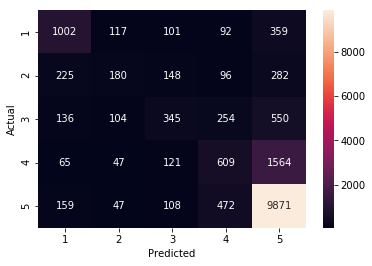

In [0]:
confusion_matrix_heatmap(clf_3, X_train, X_test, y_train, y_test)

Now let's run a learning curve. Don't worry about making sense of the code in the plot. Let's just copy and paste it in to run the learning curve.

In [0]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


By adding more data (more than our 1/10th of the dataset!), we could probably increase our accuracy. You want to see these lines converge, so that the training is not overfit and the validation accuracy is improving.

<module 'matplotlib.pyplot' from '/home/cordun/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

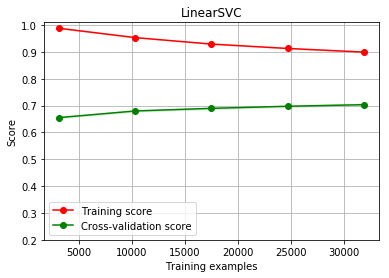

In [0]:
plot_learning_curve(clf_3, 'LinearSVC', X_train, y_train, ylim=(0.2, 1.01), cv=5, n_jobs=4)

<b><h2><font color=#ff0000>Short Break - 5 min</b></h2></font>

# H2O

With H2O we'll build a stacked ensemble:

H2O makes this easy. We will make to classification models using a Logistic Regression and Gradient Boosted Model. These models are fit on the training data. The outputs of those predictions are then fed into what is called a "Meta Learner".  That Meta Learner will be a Gradient Boosted Model. It learns on those predictions The ensemble model then learns on the predictions from the training sets, and outputs the predictions on the test. The two base learners we will build in H2O are: 
- Logistic Regression Model
- Gradient Boosted Model 


<img src="https://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier_files/stackingclassification_overview.png" width=400, height=400>

H2O will generate a "Level 1" dataset which are the predicted classes (star reviews) for each of our reviews in the training set for each of the models: n x m = len(training) x 2 <p>

At the same time, it will predict for the x_test using each of these base learners. These will generate the test predictions we'll call "meta_test". <p>

The Meta Learner will train on the Level 1 dataset.<p>

meta_learner.fit(level1, y_train)<br>
meta_learner.predict(meta_test) #will generate all the y_test labels<br>

We'll use the `H2OStackedEnsembleEstimator` metalearner setting at the default 'AUTO' and then make it a Gradient Boosted Model in itself to compare the mean squared error for each. 


<img src="https://2xbbhjxc6wk3v21p62t8n4d4-wpengine.netdna-ssl.com/wp-content/uploads/2013/11/h20_black-300x245.png">

There are a few things we need to do here in this part of the tutorial: 

- Part 1 - Prepare the data using an H2OFrame
- Part 2 - Tokenize the Reviews
- Part 3 - Train a Word2Vec model on the entire Amazon Reviews and transform the data_tu Text
- Part 4 - Partition the data into a 60/20/20 split 
- Part 5 - Develop Base Learners and stack into an Ensemble
- Part 6 - Make Predictions!




In [0]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
from __future__ import print_function
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 hour 25 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.3
H2O cluster version age:,3 days
H2O cluster name:,H2O_from_python_cordun_0n8z3h
H2O cluster total nodes:,1
H2O cluster free memory:,2.651 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"locked, healthy"


<b><h3>Part 1 - Prepping the Data</b></h3>
Data must be in an H2OFrame 
- H2OFrame is similar to pandas’ DataFrame, or R’s data.frame. One of the critical distinction is that the data is generally not held in memory, instead it is located on a (possibly remote) H2O cluster, and thus H2OFrame represents a mere handle to that data.

In [0]:
train = h2o.H2OFrame(data_tu)
train.head(2)

Parse progress: |█████████████████████████████████████████████████████████| 100%


Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,datetime
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1.30386e+09,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,2011-04-26 00:00:00
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1.34698e+09,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as """"Jumbo""",2012-09-06 00:00:00


In [0]:
train.describe()

Rows:56845
Cols:11




,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,datetime
type,int,enum,string,enum,int,int,int,int,enum,string,time
mins,1.0,,NaN,,0.0,0.0,1.0,961718400.0,,NaN,961632000000.0
mean,28423.0,,NaN,,1.615146450875185,2.084264227284717,4.145184273023132,1295378629.803853,,NaN,1295292229803.8535
maxs,56845.0,,NaN,,398.0,401.0,5.0,1351209600.0,,NaN,1351123200000.0
sigma,16409.882362974655,,NaN,,5.4468852423750835,6.105144407269138,1.3314108619987988,47217068.042775914,,NaN,47217068042.775986
zeros,0,,0,,30536,27220,0,0,,0,0
missing,0,0,0,0,0,0,0,0,0,0,0
0,1.0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1303862400.0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,2011-04-26 00:00:00
1,2.0,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1346976000.0,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as """"Jumbo""",2012-09-06 00:00:00
2,3.0,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres """"Natalia Corres",1.0,1.0,4.0,1219017600.0,"""""Delight"""" says it a","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' """"The Lion, The Witch, and The Wardrobe"""" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witc",2008-08-17 00:00:00


Need to convert our target, `Score` to a categorical because by default H2O reads in `Score` as an int. For H2O integers are used so they can be mapped to categorical (using .asfactor()). “enum” - force the column to be parsed as a categorical column. 
- If we don't do this, the models will try to predict as a regression model, not classification.

In [0]:
train['Score'] = train['Score'].asfactor()

In [0]:
train = train[['Text', 'Score']]

In [0]:
train.describe()

Rows:56845
Cols:2




,Text,Score
type,string,enum
mins,NaN,
mean,NaN,
maxs,NaN,
sigma,NaN,
zeros,0,
missing,0,0
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,5
1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as """"Jumbo""",1
2,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' """"The Lion, The Witch, and The Wardrobe"""" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witc",4


<b><h3>Part 2 - Tokenize </b></h3><br>
Word2Vec requires words, instead of sentences. So, we need to tokenize the review comments. 

In [0]:
#I did not filter out stopwords
words = (train["Text"].tokenize("\\W+")).tolower()

In [0]:
words.shape

(4743259, 1)

In [0]:
words

C1
i
have
bought
several
of
the
vitality
canned
dog
food


<b><h3>Part 3 - Train a Word2Vec Model</b></h3>

<img src="http://www.lifestyletrading101.com/wp-content/uploads/2017/03/word2-vec-king-queen.png" width=400, height=400>

It's hard to do a tutorial involving machine learning and text and <b>not</b> talk about word2vec. Each word is assigned a vector - or an array of numbers. <br>

> {
 'yellow': array([0.1,0.5,...,0.7]),
 'four': array([0.2,1.2,...,0.9]),
...
}

Word2Vec will then train the words against other words and will learn "vector representations" of the words called "embeddings", which I usually think about as groupings. Similar words will be placed close to each other in the vector space using l2 or cosine similarity. 
> Per Chollet, "Ideally, in a good embeddings space, the "path" (a vector) to go from "kitchen" and "dinner" would capture precisely the semantic relationship between these two concepts." The below Word2Vec Model was trained on the <b>entire</b> corpus of Amazon Review Comments.

<img src="https://i.ytimg.com/vi/BD8wPsr_DAI/maxresdefault.jpg" width=450 height=450>

In [0]:
#Word2Vec model - DO NOT RUN THIS AGAIN

#Takes 30 minutes to train
from h2o.estimators.word2vec import H2OWord2vecEstimator

w2v_model = H2OWord2vecEstimator(sent_sample_rate = 0.0, epochs = 10)
w2v_model.train(training_frame=words)

For H2O and Keras that we'll show in a few minutes, it's very important to save your models.  For this Word2Vec model, which saves a series of weights, it took 30 minutes to train this on my CPU. As a result, make sure you save it. Then you can reload it. In this case, in my tutorial I'm reloading it as `w2v_model_saved`.

In [0]:
#Save this model 
#w2v_path = h2o.save_model(model=w2v_model, path="/Users/catherineordun/Documents/Data/", force=True)

In [0]:
#Load the model
w2v_model_saved = h2o.load_model("Word2Vec_model_python_1520181217021_1")

In [0]:
#look at the w2v_model
w2v_model_saved


Model Details
H2OWord2vecEstimator :  Word2Vec
Model Key:  Word2Vec_model_python_1520181217021_1
No model summary for this model



<b>Similarity:</b> To make sure it's been trained correctly, you can examine similar words. In this case, since we already examined comments about the "Greenies" dog treats, let's see what similar words are associated with it.

In [0]:
#find similar words to greenies, return 5 synonyms
w2v_model_saved.find_synonyms("greenies", count = 5)

OrderedDict([('chews', 0.8017433285713196),
             ('treats', 0.7353628277778625),
             ('flossies', 0.7212197780609131),
             ('pockets', 0.6942440271377563),
             ('chewies', 0.6890543699264526)])

In [0]:
w2v_model_saved.find_synonyms("puppy", count = 5)

OrderedDict([('pup', 0.8828780055046082),
             ('chihuahua', 0.833794355392456),
             ('boxer', 0.8300634622573853),
             ('pug', 0.8200563192367554),
             ('dachshund', 0.8112979531288147)])

In [0]:
w2v_model_saved.find_synonyms("chocolate", count = 5)

OrderedDict([('choc', 0.8679807782173157),
             ('choclate', 0.8341993689537048),
             ('fudge', 0.8111635446548462),
             ('choco', 0.8091298937797546),
             ('cocoa', 0.7814701795578003)])

<b>Vectors for each Review</b>

In [0]:
#Calculate a vector for each of our 56,845 Amazon Reviews
review_vecs = w2v_model_saved.transform(words, aggregate_method = "AVERAGE")

In [0]:
#returns: a frame representing learned word embeddings
review_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
-0.0638917,-0.0970874,-0.0229077,0.0374485,0.0191146,0.0908984,-0.155164,0.169116,-0.0102696,-0.112877,0.016129,0.125112,-0.108519,-0.0789235,0.0526875,0.0663017,-0.0464606,0.0271625,0.0209955,0.116516,0.0340778,-0.146537,0.082797,-0.0107261,-0.167423,-0.0928541,0.134476,-0.072255,-0.0129085,-0.0704537,-0.0280617,0.0516229,-0.0269324,0.0337584,-0.168962,0.0594993,0.0306763,0.0126701,-0.0105427,0.0664951,-0.118319,0.0367416,0.176025,0.00999602,0.0300805,0.0526047,-0.0435279,-0.102894,-0.00939044,0.0526934,0.0764107,-0.0883502,-0.0184075,-0.030774,0.172863,-0.163176,-0.0931142,-0.226803,0.00609887,-0.0475778,-0.0194462,-0.0012172,-0.0433208,0.0239583,0.0627753,0.0191412,0.0156632,-0.0485567,-0.14872,0.141138,0.0475147,-0.0123072,0.0318328,0.0637536,0.129258,-0.0525741,-0.0050232,-0.0230209,0.0894578,-0.137852,-0.223751,0.129855,-0.0448137,-0.180338,-0.0136254,-0.10065,0.0186889,-0.258157,0.128639,0.059909,-0.00380126,-0.0884566,-0.00123465,-0.172532,0.172898,0.0372678,0.0503646,-0.0216069,-0.0506191,0.0269568
-0.0874703,-0.103785,-0.0252969,0.109868,0.168258,0.055219,-0.0736924,0.118625,0.222477,-0.122411,-0.00154151,0.0429552,-0.12498,-0.158167,0.11111,0.00340129,-0.136607,0.138722,0.0408648,0.0940657,0.0162398,-0.12484,0.0954557,0.0261558,-0.0447902,-0.108221,0.181823,-0.11829,0.141065,-0.0429287,0.0467278,0.0385937,-0.122561,0.0649171,-0.137496,0.104508,0.125232,-0.0603673,-0.0533402,0.148036,0.0214039,0.0137302,0.112151,0.0422785,0.0200145,-0.0379145,-0.0015584,-0.279246,0.0295897,0.0194942,0.0812835,0.0732763,-0.0488742,-0.0680004,0.206907,-0.0882478,-0.0829674,-0.177275,-0.178776,2.74886e-05,0.00528668,-0.0248271,-0.0703493,0.0192835,0.125574,-0.0941599,0.0923736,-0.121905,-0.143011,-0.0732549,-0.00569846,-0.085884,0.00111425,0.0489665,0.11128,-0.0786011,-0.0927645,0.1094,0.111497,-0.168089,-0.190475,-0.00307991,-0.0600311,-0.157062,0.00439327,0.0289381,-0.0519843,-0.088377,0.207547,0.118871,0.00662663,-0.103408,0.0299932,-0.136676,0.0709788,0.0364537,-0.0345578,-0.021131,-0.119932,0.0845786
-0.0715167,-0.132637,-0.0886205,0.068643,0.0970509,0.0356156,-0.15483,0.140713,0.0659837,-0.109694,0.0350943,0.037304,-0.000283768,-0.150069,0.0342204,-0.0318355,-0.0896158,0.0757564,-0.0140555,0.0446606,0.0477406,-0.171458,0.0404152,-0.015218,-0.0698312,-0.185326,0.14766,-0.0761993,0.0453683,-0.0817592,-0.0541848,0.0910094,-0.0718377,-0.0364756,-0.0924691,0.00670849,0.100109,-0.0391601,0.0372554,0.0689392,-0.0102677,-0.0249556,0.145191,0.0222904,-0.0197326,-0.0533293,-0.0703884,-0.149496,0.00357082,0.0295466,0.155179,-0.068091,0.0116285,-0.00730066,0.15968,-0.0504936,-0.0912443,-0.104022,0.0060169,-0.0468523,-0.00467846,-0.037835,-0.082811,-0.0229097,0.0669015,-0.0713643,0.0291742,-0.10356,-0.117136,0.0925314,0.0389292,-0.0295042,0.0818141,-0.00320993,0.126077,-0.0486806,-0.0664729,0.00760109,0.0843409,-0.124104,-0.277001,0.0602317,-0.0451036,-0.13677,-0.000548473,-0.0528045,0.0288046,-0.180904,0.163556,0.0395737,-0.0237387,-0.125259,0.0280979,-0.150083,0.139412,0.108496,0.0188306,-0.0381084,-0.148919,0.0155871
-0.0166435,-0.148646,-0.147936,0.107414,-0.00411628,0.0504465,-0.145867,0.126312,0.0982014,-0.062528,-2.22265e-05,0.00365633,-0.0471989,-0.156235,0.0627832,-0.0486262,-0.16127,0.0477404,0.0327939,0.0925189,-0.00747836,-0.124338,0.0478476,-0.0656661,-0.0754735,-0.192778,0.0769478,-0.0563235,0.0584473,9.06041e-05,-0.0953962,0.0485756,-0.0582104,0.0294454,-0.155739,0.0092849,0.0379736,0.0357492,0.0668411,-0.000349623,-0.0560362,0.0349262,0.208597,0.0116532,0.0140845,-0.0705178,-0.122815,-0.117249,-0.0122824,0.00898791,0.13964,-0.0422121,0.0104174

In [0]:
review_vecs.shape

(56845, 100)

<b><h3>Part 4 - Partitioning the Data</b></h3>

In [0]:
#Partitioning into Train/Test Split
#Keeping only those review_vecs that have no 'NaN's

valid_reviews = ~ review_vecs["C1"].isna()


#for each of the valid_reviews, remember the ones that do not have 'NaN's, add the associated vectors
# use H2O's 'cbind' function
#this is now 'data'
data = train[valid_reviews,:].cbind(review_vecs[valid_reviews,:])

#now split this data by an 80%, 20% train/test split using H2O's 'split_frame' function
#data_split = data.split_frame(ratios=[0.8])

In [0]:
data.head(1)

Text,Score,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,5,-0.0638917,-0.0970874,-0.0229077,0.0374485,0.0191146,0.0908984,-0.155164,0.169116,-0.0102696,-0.112877,0.016129,0.125112,-0.108519,-0.0789235,0.0526875,0.0663017,-0.0464606,0.0271625,0.0209955,0.116516,0.0340778,-0.146537,0.082797,-0.0107261,-0.167423,-0.0928541,0.134476,-0.072255,-0.0129085,-0.0704537,-0.0280617,0.0516229,-0.0269324,0.0337584,-0.168962,0.0594993,0.0306763,0.0126701,-0.0105427,0.0664951,-0.118319,0.0367416,0.176025,0.00999602,0.0300805,0.0526047,-0.0435279,-0.102894,-0.00939044,0.0526934,0.0764107,-0.0883502,-0.0184075,-0.030774,0.172863,-0.163176,-0.0931142,-0.226803,0.00609887,-0.0475778,-0.0194462,-0.0012172,-0.0433208,0.0239583,0.0627753,0.0191412,0.0156632,-0.0485567,-0.14872,0.141138,0.0475147,-0.0123072,0.0318328,0.0637536,0.129258,-0.0525741,-0.0050232,-0.0230209,0.0894578,-0.137852,-0.223751,0.129855,-0.0448137,-0.180338,-0.0136254,-0.10065,0.0186889,-0.258157,0.128639,0.059909,-0.00380126,-0.0884566,-0.00123465,-0.172532,0.172898,0.0372678,0.0503646,-0.0216069,-0.0506191,0.0269568


In [0]:
#split the data into three pieces: 60% for training, 20% for validation, 20% for final testing
train, valid, test = data.split_frame(
    ratios=[0.6,0.2], 
    seed=1234
)

<b><h3>Part 5 - Build two baseline models</b></h3>
- Log Reg on 3 folds Cross Validation 
- Gradient Boosted Machine on 3 folds Cross Validation
- NOTE: fold assignment and nfolds must be the same for both estimators

In [0]:
#Logistic Regression 
cv_log = H2OGeneralizedLinearEstimator(family='multinomial', 
                                       solver='L_BFGS',
                                       fold_assignment="Modulo",
                                       nfolds = 3,
                                      keep_cross_validation_predictions=True)

cv_log.train(x = review_vecs.names, 
             y = "Score", 
             training_frame=train)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [0]:
#cv_gbm = H2OGradientBoostingEstimator(nfolds = 5)

cv_gbm = H2OGradientBoostingEstimator(nfolds=3,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True)

cv_gbm.train(x = review_vecs.names, 
             y = "Score",
             training_frame=train)


gbm Model Build progress: |███████████████████████████████████████████████| 100%


<b>Variable Importance</b> Let's see which word embedding is the most predictive specifically for one of our base models.

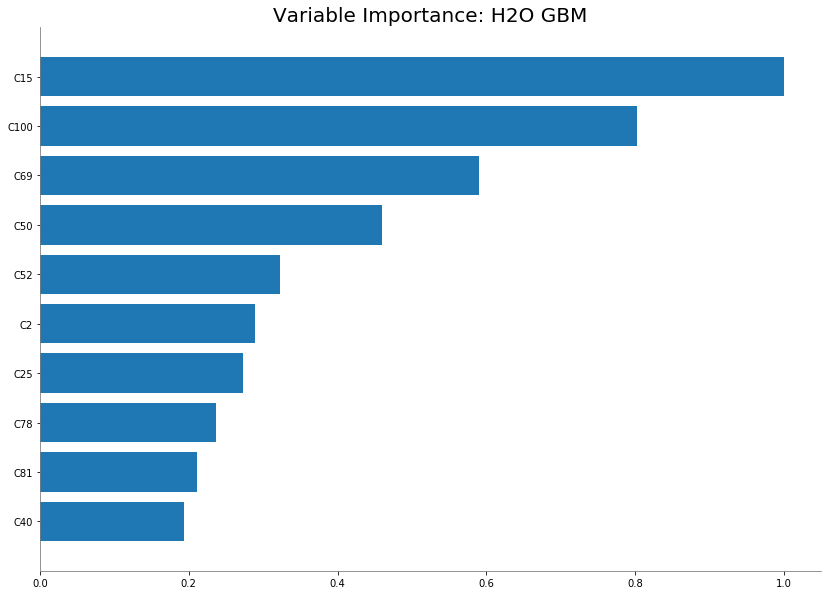

In [0]:
cv_gbm.varimp_plot()

In [0]:
#since the NLP part of H2O is a little out of scope of this tutorial
#I used some code courtesy of https://www.youtube.com/watch?v=_5V8bVthLiA

unique_words = words.asfactor().ascharacter()
unique_words.col_names=['Word']
word_embeddings = w2v_model_saved.transform(unique_words, aggregate_method = 'None')
word_embeddings = unique_words.cbind(word_embeddings)
word_embeddings= word_embeddings[~(word_embeddings['C15'].isna())]

H2OServerError: HTTP 500 Server Error:
Server error water.util.DistributedException:
  Error: DistributedException from /127.0.0.1:54321: 'GC overhead limit exceeded'
  Request: None


/home/cordun/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


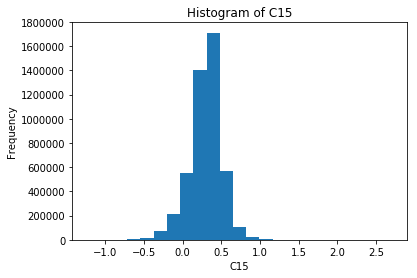

In [0]:
word_embeddings['C15'].hist()

In [0]:
lowwords = word_embeddings[word_embeddings['C15'] < 0.1]
lowwords[['Word', 'C15']].head(15)

In [0]:
highwords = word_embeddings[word_embeddings['C15'] > 0.5]
highwords[['Word', 'C15']].head(15)

<b><h3>Part 6 - Ensemble Model</b></h3>

In [0]:
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

# Train a stacked ensemble using the GBM and GLM above
ensemble = H2OStackedEnsembleEstimator(model_id="wids_ensemble",
                                       base_models=[cv_log, cv_gbm])

In [0]:
ensemble.train(x = review_vecs.names, y = "Score", training_frame=train)

H2OResponseError: ModelBuilderErrorV3  (water.exceptions.H2OModelBuilderIllegalArgumentException):
    timestamp = 1520360511265
    error_url = '/99/ModelBuilders/stackedensemble'
    msg = 'Illegal argument(s) for StackedEnsemble model: wids_ensemble.  Details: ERRR on field: _train: Missing training frame: py_10_sid_96ad'
    dev_msg = 'Illegal argument(s) for StackedEnsemble model: wids_ensemble.  Details: ERRR on field: _train: Missing training frame: py_10_sid_96ad'
    http_status = 412
    values = {'messages': [{'_log_level': 1, '_field_name': '_train', '_message': 'Missing training frame: py_10_sid_96ad'}], 'algo': 'StackedEnsemble', 'parameters': {'_train': {'name': 'py_10_sid_96ad', 'type': 'Key'}, '_valid': None, '_nfolds': 0, '_keep_cross_validation_predictions': False, '_keep_cross_validation_fold_assignment': False, '_parallelize_cross_validation': True, '_auto_rebalance': True, '_seed': -1, '_fold_assignment': 'AUTO', '_categorical_encoding': 'AUTO', '_max_categorical_levels': 10, '_distribution': 'AUTO', '_tweedie_power': 1.5, '_quantile_alpha': 0.5, '_huber_alpha': 0.9, '_ignored_columns': ['Text'], '_ignore_const_cols': True, '_weights_column': None, '_offset_column': None, '_fold_column': None, '_is_cv_model': False, '_score_each_iteration': False, '_max_runtime_secs': 0.0, '_stopping_rounds': 0, '_stopping_metric': 'AUTO', '_stopping_tolerance': 0.001, '_response_column': 'Score', '_balance_classes': False, '_max_after_balance_size': 5.0, '_class_sampling_factors': None, '_max_confusion_matrix_size': 20, '_checkpoint': None, '_pretrained_autoencoder': None, '_custom_metric_func': None, '_base_models': [{'name': 'GLM_model_python_1520359732201_1', 'type': 'Key'}, {'name': 'GBM_model_python_1520359732201_2', 'type': 'Key'}], '_keep_levelone_frame': False, '_metalearner_nfolds': 0, '_metalearner_fold_assignment': None, '_metalearner_fold_column': None, '_metalearner_algorithm': 'AUTO', '_metalearner_params': ''}, 'error_count': 2}
    exception_msg = 'Illegal argument(s) for StackedEnsemble model: wids_ensemble.  Details: ERRR on field: _train: Missing training frame: py_10_sid_96ad'
    stacktrace =
        water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for StackedEnsemble model: wids_ensemble.  Details: ERRR on field: _train: Missing training frame: py_10_sid_96ad
        water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
        hex.ModelBuilder.trainModel(ModelBuilder.java:231)
        water.api.ModelBuilderHandler.handle(ModelBuilderHandler.java:64)
        water.api.ModelBuilderHandler.handle(ModelBuilderHandler.java:17)
        water.api.RequestServer.serve(RequestServer.java:451)
        water.api.RequestServer.doGeneric(RequestServer.java:296)
        water.api.RequestServer.doPost(RequestServer.java:222)
        javax.servlet.http.HttpServlet.service(HttpServlet.java:755)
        javax.servlet.http.HttpServlet.service(HttpServlet.java:848)
        org.eclipse.jetty.servlet.ServletHolder.handle(ServletHolder.java:684)
        org.eclipse.jetty.servlet.ServletHandler.doHandle(ServletHandler.java:503)
        org.eclipse.jetty.server.handler.ContextHandler.doHandle(ContextHandler.java:1086)
        org.eclipse.jetty.servlet.ServletHandler.doScope(ServletHandler.java:429)
        org.eclipse.jetty.server.handler.ContextHandler.doScope(ContextHandler.java:1020)
        org.eclipse.jetty.server.handler.ScopedHandler.handle(ScopedHandler.java:135)
        org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:154)
        org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:116)
        water.JettyHTTPD$LoginHandler.handle(JettyHTTPD.java:197)
        org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:154)
        org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:116)
        org.eclipse.jetty.server.Server.handle(Server.java:370)
        org.eclipse.jetty.server.AbstractHttpConnection.handleRequest(AbstractHttpConnection.java:494)
        org.eclipse.jetty.server.BlockingHttpConnection.handleRequest(BlockingHttpConnection.java:53)
        org.eclipse.jetty.server.AbstractHttpConnection.content(AbstractHttpConnection.java:982)
        org.eclipse.jetty.server.AbstractHttpConnection$RequestHandler.content(AbstractHttpConnection.java:1043)
        org.eclipse.jetty.http.HttpParser.parseNext(HttpParser.java:865)
        org.eclipse.jetty.http.HttpParser.parseAvailable(HttpParser.java:240)
        org.eclipse.jetty.server.BlockingHttpConnection.handle(BlockingHttpConnection.java:72)
        org.eclipse.jetty.server.bio.SocketConnector$ConnectorEndPoint.run(SocketConnector.java:264)
        org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:608)
        org.eclipse.jetty.util.thread.QueuedThreadPool$3.run(QueuedThreadPool.java:543)
        java.lang.Thread.run(Thread.java:748)
    parameters = {'__meta': {'schema_version': 99, 'schema_name': 'StackedEnsembleParametersV99', 'schema_type': 'StackedEnsembleParameters'}, 'model_id': None, 'training_frame': None, 'validation_frame': None, 'nfolds': 0, 'keep_cross_validation_predictions': False, 'keep_cross_validation_fold_assignment': False, 'parallelize_cross_validation': True, 'distribution': 'AUTO', 'tweedie_power': 1.5, 'quantile_alpha': 0.5, 'huber_alpha': 0.9, 'response_column': {'__meta': {'schema_version': 3, 'schema_name': 'ColSpecifierV3', 'schema_type': 'VecSpecifier'}, 'column_name': 'Score', 'is_member_of_frames': None}, 'weights_column': None, 'offset_column': None, 'fold_column': None, 'fold_assignment': 'AUTO', 'categorical_encoding': 'AUTO', 'max_categorical_levels': 10, 'ignored_columns': ['Text'], 'ignore_const_cols': True, 'score_each_iteration': False, 'checkpoint': None, 'stopping_rounds': 0, 'max_runtime_secs': 0.0, 'stopping_metric': 'AUTO', 'stopping_tolerance': 0.001, 'custom_metric_func': None, 'base_models': [{'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GLM_model_python_1520359732201_1', 'type': 'Key<Model>', 'URL': '/3/Models/GLM_model_python_1520359732201_1'}, {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GBM_model_python_1520359732201_2', 'type': 'Key<Model>', 'URL': '/3/Models/GBM_model_python_1520359732201_2'}], 'metalearner_algorithm': 'AUTO', 'metalearner_nfolds': 0, 'metalearner_fold_assignment': None, 'metalearner_fold_column': None, 'keep_levelone_frame': False, 'metalearner_params': '', 'seed': -1}
    messages = [{'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'train', 'message': 'Missing training frame: py_10_sid_96ad'}]
    error_count = 2


In [0]:

# Eval ensemble performance on the test data
perf_stack_test = ensemble.model_performance(test)

In [0]:
# Compare to base learner performance on the test set
perf_log_test = cv_log.model_performance(test)
perf_gbm_test = cv_gbm.model_performance(test)


In [0]:
perf_log_test


ModelMetricsMultinomialGLM: glm
** Reported on test data. **

MSE: 0.28771184893858776
RMSE: 0.5363877785134443


In [0]:
perf_gbm_test


ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.2998173092572715
RMSE: 0.547555759039453
LogLoss: 0.8786030622350028
Mean Per-Class Error: 0.6652114507173037
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
461.0,21.0,34.0,38.0,515.0,0.5687558,"608 / 1,069"
133.0,34.0,54.0,60.0,370.0,0.9477727,617 / 651
87.0,24.0,103.0,96.0,574.0,0.8834842,781 / 884
41.0,10.0,65.0,168.0,1358.0,0.8976857,"1,474 / 1,642"
75.0,3.0,35.0,89.0,6921.0,0.0283588,"202 / 7,123"
797.0,92.0,291.0,451.0,9738.0,0.3238631,"3,682 / 11,369"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.6761369
2,0.8425543
3,0.9151201
4,0.9624417
5,1.0


In [0]:
baselearner_best_MSE_test = max(perf_log_test.mse(), perf_gbm_test.mse())


In [0]:
baselearner_best_MSE_test

0.2998173092572715

In [0]:
stack_mse_test = perf_stack_test.mse()
print("Best Base-learner Test MSE:  {0}".format(baselearner_best_MSE_test))
print("Ensemble Test MSE:  {0}".format(stack_mse_test))



Best Base-learner Test MSE:  0.2998173092572715
Ensemble Test MSE:  0.2837981137031448


In [0]:
# Generate predictions on a test set (if neccessary)
pred = ensemble.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [0]:
pred

predict,p1,p2,p3,p4,p5
5,0.183075,0.151676,0.155385,0.210616,0.299247
5,0.0103048,0.00542052,0.00979379,0.0534944,0.920986
5,0.0109721,0.00586564,0.0105731,0.0560388,0.91655
5,0.0146313,0.00714121,0.0120886,0.0582031,0.907936
5,0.133741,0.0438559,0.0455557,0.0800565,0.696791
5,0.0184162,0.0131072,0.0279752,0.130249,0.810253
5,0.0104186,0.00509825,0.00874588,0.048764,0.926973
5,0.0174613,0.011333,0.0230689,0.0926349,0.855502
5,0.139384,0.0552792,0.0495661,0.076254,0.679517
5,0.0231643,0.0121331,0.0197197,0.0751074,0.869876


<b><h3>Predict on a new review!</b></h3>
Code below adopted from  https://github.com/h2oai/h2o-3/blob/master/h2o-py/demos/word2vec_craigslistjobtitles.ipynb

In [0]:
def tokenize(sentences):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    return tokenized_words

In [0]:
def predict(review,w2v, gbm):
    words = tokenize(h2o.H2OFrame(review).ascharacter())
    review_vec = w2v.transform(words, aggregate_method="AVERAGE")
    print(ensemble.predict(test_data=review_vec))

![Screen%20Shot%202018-03-05%20at%205.31.20%20PM.png](attachment:Screen%20Shot%202018-03-05%20at%205.31.20%20PM.png)

In [0]:
print(predict(["I don't know If I will order again, cause I would prefer not to get flavors I don't like,"], w2v_model_saved, ensemble))

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,p1,p2,p3,p4,p5
1,0.540206,0.235682,0.14968,0.0289766,0.0454553



None


![Screen%20Shot%202018-03-05%20at%205.32.36%20PM.png](attachment:Screen%20Shot%202018-03-05%20at%205.32.36%20PM.png)

In [0]:
print(predict(["I love it - although some of the flavors are too sweet or just not my style, the ones that I do enjoy (Blueberry Lemonade, Strawberry Lemonade, Pomegranate, Blueberry...) have become highly addicting. Great product - great deal!"], 
              w2v_model_saved, 
              ensemble))

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,p1,p2,p3,p4,p5
5,0.0186631,0.014054,0.0306549,0.149594,0.787034



None


But even when we told the model that it was a 4-star review, it still had a hard time figuring it out!

![Screen%20Shot%202018-03-05%20at%205.34.15%20PM.png](attachment:Screen%20Shot%202018-03-05%20at%205.34.15%20PM.png)

In [0]:
print(predict(["I love the Bai drinks they’re awesome. The reason for 4 stars not 5 is that with my last variey box I received only 3 flavors instead of 4; I received 6 watermelon instead of 3 watermelon and 3 blueberry lemonade. Watermelon is my least favorite flavor I just put up with it because I love the other flavors and that variety box."], 
              w2v_model_saved, 
              ensemble))

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,p1,p2,p3,p4,p5
5,0.0543729,0.0629869,0.133077,0.276741,0.472822



None


And this prediction was way off.

![Screen%20Shot%202018-03-05%20at%205.35.38%20PM.png](attachment:Screen%20Shot%202018-03-05%20at%205.35.38%20PM.png)

In [0]:
print(predict(["The product Bai Strwberry Lemonade is fine. I ordered two boxes and the outer box was too heavy to lift. So I took out the inner container which was really a box bottom with 12 bottles and a lastic cover. Very flimsy the bottles had fallen out and kept falling out. Very hard to carry."], 
              w2v_model_saved, 
              ensemble))

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,p1,p2,p3,p4,p5
1,0.388241,0.243714,0.167377,0.0964125,0.104256



None


Looks like our model doesn't know that DayQuil isn't good!
![Screen%20Shot%202018-03-05%20at%205.38.00%20PM.png](attachment:Screen%20Shot%202018-03-05%20at%205.38.00%20PM.png)

In [0]:
print(predict(["Love the coconut, but the red one tastes exactly like DayQuil."], 
              w2v_model_saved, 
              ensemble))

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,p1,p2,p3,p4,p5
5,0.154057,0.141584,0.0773158,0.102141,0.524902



None


Two-star ratings continue to be challenging for the model.
![Screen%20Shot%202018-03-05%20at%205.39.28%20PM.png](attachment:Screen%20Shot%202018-03-05%20at%205.39.28%20PM.png)

In [0]:
print(predict(["Just not for me. It tastes like watered down juice."], 
              w2v_model_saved, 
              ensemble))

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,p1,p2,p3,p4,p5
1,0.640756,0.218555,0.101049,0.0186073,0.0210322



None


In [0]:
metalearner_algorithm

In [0]:
# Train a stacked ensemble using the GBM and GLM above
ensemble = H2OStackedEnsembleEstimator(model_id="wids_ensemble_gbm",
                                       metalearner_algorithm = 'gbm',
                                       base_models=[cv_log, cv_gbm])

In [0]:
ensemble.train(x = review_vecs.names, y = "Score", training_frame=train)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


In [0]:
# Eval ensemble performance on the test data
perf_stack_test = ensemble.model_performance(test)
print(perf_stack_test.mse())

0.28278616986758504


Using a Gradient Boosted Machine as the super learner itself yielded a slightly lower MSE than using the default 'AUTO' setting for the metalearner algorithm.  The previous ensemble Test MSE was 0.2837981137031448.

# Keras

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
import tensorflow as tf

Using TensorFlow backend.


In [0]:
data_for_model = data_tu[['Score', 'Text']].copy()

X = data_for_model['Text']
y = data_for_model['Score']


In [0]:
data_for_model.dtypes

Score     int64
Text     object
dtype: object

This time, let's keep the Score as an integer, because using Keras built-in categorical functions, it will transform it to categorical later on.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

<b><h3>Part 1 - Yes, preprocessing</b></h3>

<b>Count document length</b> - We need to find the maximum number of words in each 'document', which is in our case, each review. This will help in our preprocessing using Keras. To do this, let's tokenize each review using nltk and find the maximum number of tokens for our entire dataset.

In [0]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
data_for_model['tokens'] = data_for_model['Text'].map(lambda x: tokenizer.tokenize(x))


In [0]:
data_for_model['token_count'] = data_for_model['tokens'].map(lambda x: len(x))

In [0]:
data_for_model['token_count'][:5]

0    48
1    32
2    93
3    41
4    27
Name: token_count, dtype: int64

In [0]:
max(data_for_model['token_count'])

1769

<b>New Easier Keras Method</b><br>
The below tutorial was adopted from https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html. 

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

texts = X

tokenizer = Tokenizer(nb_words=max(data_for_model['token_count']))
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


/home/cordun/anaconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:157: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 45980 unique tokens.


In [0]:
word_index.items()

dict_items([('the', 1), ('i', 2), ('and', 3), ('a', 4), ('to', 5), ('it', 6), ('of', 7), ('is', 8), ('this', 9), ('br', 10), ('for', 11), ('in', 12), ('my', 13), ('that', 14), ('but', 15), ('with', 16), ('have', 17), ('not', 18), ('you', 19), ('are', 20), ('was', 21), ('they', 22), ('as', 23), ('on', 24), ('like', 25), ('so', 26), ('these', 27), ('them', 28), ('good', 29), ('be', 30), ('at', 31), ('or', 32), ('taste', 33), ('just', 34), ('one', 35), ('very', 36), ('if', 37), ('great', 38), ('product', 39), ('all', 40), ('flavor', 41), ('from', 42), ('coffee', 43), ('can', 44), ("it's", 45), ('when', 46), ('tea', 47), ('more', 48), ('we', 49), ('has', 50), ('me', 51), ('love', 52), ('will', 53), ('would', 54), ('had', 55), ('food', 56), ('out', 57), ('than', 58), ('other', 59), ('no', 60), ('get', 61), ('some', 62), ('about', 63), ('up', 64), ('really', 65), ('amazon', 66), ('only', 67), ('too', 68), ('much', 69), ('an', 70), ("don't", 71), ('your', 72), ('because', 73), ('also', 74), (

<b>keras.utils.to_categorical</b><br>
Converts a class vector (integers) to binary class matrix.<br>

E.g. for use with categorical_crossentropy.<br>

Arguments:<br>

- y: class vector to be converted into a matrix (integers from 0 to num_classes).
- num_classes: total number of classes.

Returns<br>

A binary matrix representation of the input.

In [0]:
from keras.utils import to_categorical 

max_words = max(data_for_model['token_count'])
data = pad_sequences(sequences, maxlen=max_words)

labels = y
labels = to_categorical(np.asarray(labels))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


Shape of data tensor: (56845, 1769)
Shape of label tensor: (56845, 6)


In [0]:
data.shape[0]

56845

In [0]:
# split the data into a training set and a validation set


#frst shuffle the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)


data = data[indices] #features
labels = labels[indices] #labels

#split it 80/20
nb_validation_samples = int(0.2 * data.shape[0])

In [0]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [0]:
x_train.shape

(45476, 1769)

In [0]:
x_val.shape

(11369, 1769)

<b><h3> Part 2 - Get Word Embeddings to build an Embedding Layer using GloVe:</b></h3><br>

Like word2vec that we used in H2O, we're going to use GloVe: https://nlp.stanford.edu/projects/glove/

Word2Vec is a neural network that predicts the context of a word with respect to other words. Every word in a Word2Vec model has a weight. It goes from the <b>embedding (the small vector of words)</b> to the context (the output/weights). GloVe, on the other hand, uses matrix factorization to decompose a co-occurence matrix. A co-occurence matrix counts up the number of times each word in an Amazon Review appear with other words: how many times does 'greenie' occur with 'dog' versus 'greenie' occurs with 'chocolate'. This table could be really big like 100,000 by 100,000 words! But if you decompose it to two smaller matrices, it will give you the meaning of each word through the dot product and the embedding.

<img src="https://4.bp.blogspot.com/-95QD5t9Lha4/Wd7uWnBZBeI/AAAAAAAADg4/xB4VnnxM0UgUp15lNmB3aHCXYGejpm4OACLcBGAs/s1600/matrix_factorization.png">

macheads101 gives a good tutorial explanation: https://www.youtube.com/watch?v=5PL0TmQhItY

In [0]:
#compute an index mapping words to known embeddings
import os

embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embeddings_index

{'petapa': array([-0.31259999,  1.16499996, -0.020891  , -0.27928001,  0.33328   ,
         0.62121999,  0.55633003, -0.19311   ,  0.31099999,  0.20136   ,
         0.013524  ,  0.22644   , -0.33072001, -0.084095  ,  0.23763999,
         0.19812   , -0.11718   ,  0.66285002,  0.52073002, -0.11427   ,
        -0.70892   ,  0.31527999,  0.103     ,  0.61786997, -0.93300998,
         0.60812002, -0.40125   , -0.49336001, -0.45859   ,  0.14493001,
        -0.03366   , -0.68822002, -0.024664  , -0.74502999, -1.04289997,
        -0.073156  ,  0.21038   , -0.25589001,  0.40755001,  0.22328   ,
         1.48440003, -1.74030006, -0.25501001, -0.47582   , -0.40762001,
        -0.2483    , -0.52311999,  0.043814  ,  0.72995001,  0.51288998,
        -0.28046   , -0.72092003, -0.98940003, -0.28591001, -0.6178    ,
         0.64881998,  0.45332   ,  0.37814999, -0.78917998, -0.27794999,
        -0.89547002, -1.13929999,  0.55593997, -0.36897999, -0.322     ,
         0.25487   ,  0.15988   ,  0.3497

Use the embedding_index dictionary and word_index to compute our embedding matrix.

In [0]:
EMBEDDING_DIM = 100

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.046539  ,  0.61966002,  0.56647003, ..., -0.37616   ,
        -0.032502  ,  0.80620003],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Load the embedding matrix into a Keras Embedding layer. `trainable=False` to prevent the weights from being updated during training. 
> All that the Embedding layer does is to map the integer inputs to the vectors found at the corresponding index in the embedding matrix, i.e. the sequence [1, 2] would be converted to [embeddings[1], embeddings[2]]. This means that the output of the Embedding layer will be a 3D tensor of shape (samples, sequence_length, embedding_dim).

In [0]:
from keras.layers import Embedding

MAX_SEQUENCE_LENGTH = max_words

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

<b><h3>Part 3 - Build the convolutional neural network.</b></h3>

In [0]:
from keras.layers import Dense, Input, GlobalMaxPooling1D

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedded_sequences = embedding_layer(sequence_input)

In [0]:
sequence_input.shape

TensorShape([Dimension(None), Dimension(1769)])

In [0]:
embedded_sequences.shape

TensorShape([Dimension(None), Dimension(1769), Dimension(100)])

Need an architecture diagram here

In [0]:
from keras import layers
from keras import models
from keras import optimizers 
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten

x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)

x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)

x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling

x = Flatten()(x)
x = Dense(128, activation='relu')(x)


In [0]:
preds = Dense(len(labels[indices][1]), activation='softmax')(x)

#model = Model(inputs=a, outputs=b)
model = Model(sequence_input, preds)


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1769)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1769, 100)         4598100   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1765, 128)         64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 353, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 349, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 69, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 128)           82048     
__________

In [0]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=2, batch_size=128)

Train on 45476 samples, validate on 11369 samples
Epoch 1/2


25856/45476 [================>.............] - ETA: 13:52 - loss: 1.7918 - acc: 0.0000e+ - ETA: 11:50 - loss: 1.7906 - acc: 0.2695   - ETA: 10:41 - loss: 1.7895 - acc: 0.37 - ETA: 10:28 - loss: 1.7886 - acc: 0.43 - ETA: 9:50 - loss: 1.7877 - acc: 0.4719 - ETA: 9:47 - loss: 1.7869 - acc: 0.496 - ETA: 9:28 - loss: 1.7862 - acc: 0.512 - ETA: 9:18 - loss: 1.7857 - acc: 0.527 - ETA: 9:19 - loss: 1.7834 - acc: 0.543 - ETA: 9:10 - loss: 1.7773 - acc: 0.555 - ETA: 8:58 - loss: 1.7654 - acc: 0.559 - ETA: 8:54 - loss: 1.7390 - acc: 0.569 - ETA: 8:48 - loss: 1.7084 - acc: 0.570 - ETA: 8:45 - loss: 1.6812 - acc: 0.571 - ETA: 8:40 - loss: 1.6589 - acc: 0.570 - ETA: 8:40 - loss: 1.6323 - acc: 0.572 - ETA: 8:48 - loss: 1.6071 - acc: 0.576 - ETA: 8:57 - loss: 1.5735 - acc: 0.585 - ETA: 8:52 - loss: 1.5530 - acc: 0.588 - ETA: 8:48 - loss: 1.5338 - acc: 0.591 - ETA: 8:48 - loss: 1.5200 - acc: 0.592 - ETA: 8:46 - loss: 1.5051 - acc: 0.593 - ETA: 8:40 - loss: 1.4903 - acc: 0.595 - ETA: 8:36 - loss: 1.4751

45476/45476 [==============================] - ETA: 3:44 - loss: 1.2072 - acc: 0.623 - ETA: 3:43 - loss: 1.2068 - acc: 0.623 - ETA: 3:41 - loss: 1.2066 - acc: 0.623 - ETA: 3:40 - loss: 1.2063 - acc: 0.623 - ETA: 3:38 - loss: 1.2071 - acc: 0.623 - ETA: 3:37 - loss: 1.2068 - acc: 0.623 - ETA: 3:36 - loss: 1.2069 - acc: 0.623 - ETA: 3:34 - loss: 1.2067 - acc: 0.623 - ETA: 3:32 - loss: 1.2067 - acc: 0.622 - ETA: 3:31 - loss: 1.2066 - acc: 0.622 - ETA: 3:30 - loss: 1.2072 - acc: 0.622 - ETA: 3:28 - loss: 1.2069 - acc: 0.622 - ETA: 3:27 - loss: 1.2062 - acc: 0.623 - ETA: 3:25 - loss: 1.2064 - acc: 0.623 - ETA: 3:23 - loss: 1.2064 - acc: 0.622 - ETA: 3:22 - loss: 1.2063 - acc: 0.622 - ETA: 3:21 - loss: 1.2058 - acc: 0.622 - ETA: 3:19 - loss: 1.2058 - acc: 0.622 - ETA: 3:18 - loss: 1.2053 - acc: 0.623 - ETA: 3:16 - loss: 1.2059 - acc: 0.622 - ETA: 3:15 - loss: 1.2061 - acc: 0.622 - ETA: 3:13 - loss: 1.2061 - acc: 0.622 - ETA: 3:12 - loss: 1.2061 - acc: 0.622 - ETA: 3:10 - loss: 1.2062 - acc: 0

26112/45476 [================>.............] - ETA: 9:48 - loss: 1.1821 - acc: 0.640 - ETA: 8:58 - loss: 1.0801 - acc: 0.675 - ETA: 8:38 - loss: 1.1012 - acc: 0.664 - ETA: 8:34 - loss: 1.0995 - acc: 0.658 - ETA: 8:21 - loss: 1.1152 - acc: 0.654 - ETA: 8:25 - loss: 1.1098 - acc: 0.664 - ETA: 8:32 - loss: 1.1239 - acc: 0.659 - ETA: 8:48 - loss: 1.1152 - acc: 0.662 - ETA: 8:43 - loss: 1.1132 - acc: 0.660 - ETA: 8:35 - loss: 1.1185 - acc: 0.658 - ETA: 8:33 - loss: 1.1366 - acc: 0.648 - ETA: 8:31 - loss: 1.1506 - acc: 0.638 - ETA: 8:29 - loss: 1.1560 - acc: 0.635 - ETA: 8:23 - loss: 1.1586 - acc: 0.634 - ETA: 8:19 - loss: 1.1538 - acc: 0.636 - ETA: 8:18 - loss: 1.1484 - acc: 0.638 - ETA: 8:14 - loss: 1.1536 - acc: 0.635 - ETA: 8:07 - loss: 1.1556 - acc: 0.635 - ETA: 8:09 - loss: 1.1527 - acc: 0.635 - ETA: 8:11 - loss: 1.1597 - acc: 0.632 - ETA: 8:13 - loss: 1.1604 - acc: 0.632 - ETA: 8:12 - loss: 1.1568 - acc: 0.633 - ETA: 8:09 - loss: 1.1586 - acc: 0.632 - ETA: 8:06 - loss: 1.1614 - acc: 0

39808/45476 [=========================>....] - ETA: 3:34 - loss: 1.1609 - acc: 0.628 - ETA: 3:33 - loss: 1.1608 - acc: 0.628 - ETA: 3:32 - loss: 1.1618 - acc: 0.628 - ETA: 3:30 - loss: 1.1620 - acc: 0.627 - ETA: 3:29 - loss: 1.1620 - acc: 0.627 - ETA: 3:27 - loss: 1.1623 - acc: 0.627 - ETA: 3:26 - loss: 1.1631 - acc: 0.627 - ETA: 3:25 - loss: 1.1634 - acc: 0.627 - ETA: 3:23 - loss: 1.1633 - acc: 0.627 - ETA: 3:22 - loss: 1.1629 - acc: 0.627 - ETA: 3:21 - loss: 1.1631 - acc: 0.627 - ETA: 3:19 - loss: 1.1628 - acc: 0.627 - ETA: 3:18 - loss: 1.1624 - acc: 0.627 - ETA: 3:16 - loss: 1.1620 - acc: 0.627 - ETA: 3:15 - loss: 1.1618 - acc: 0.628 - ETA: 3:14 - loss: 1.1621 - acc: 0.627 - ETA: 3:12 - loss: 1.1627 - acc: 0.627 - ETA: 3:11 - loss: 1.1630 - acc: 0.627 - ETA: 3:09 - loss: 1.1628 - acc: 0.627 - ETA: 3:08 - loss: 1.1626 - acc: 0.627 - ETA: 3:06 - loss: 1.1627 - acc: 0.627 - ETA: 3:05 - loss: 1.1625 - acc: 0.627 - ETA: 3:04 - loss: 1.1630 - acc: 0.627 - ETA: 3:02 - loss: 1.1634 - acc: 0